In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    


In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


In [9]:
gender

Pipeline(steps=[('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))])

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [11]:
final_transformers

[('Geography',
  Pipeline(steps=[('selector', FeatureSelector(column='Geography')),
                  ('ohe', OHEEncoder(key='Geography'))])),
 ('Gender', Pipeline(steps=[('selector', FeatureSelector(column='Gender')),
                  ('ohe', OHEEncoder(key='Gender'))])),
 ('Tenure', Pipeline(steps=[('selector', FeatureSelector(column='Tenure')),
                  ('ohe', OHEEncoder(key='Tenure'))])),
 ('HasCrCard',
  Pipeline(steps=[('selector', FeatureSelector(column='HasCrCard')),
                  ('ohe', OHEEncoder(key='HasCrCard'))])),
 ('IsActiveMember',
  Pipeline(steps=[('selector', FeatureSelector(column='IsActiveMember')),
                  ('ohe', OHEEncoder(key='IsActiveMember'))])),
 ('CreditScore',
  Pipeline(steps=[('selector', NumberSelector(key='CreditScore'))])),
 ('Age', Pipeline(steps=[('selector', NumberSelector(key='Age'))])),
 ('Balance', Pipeline(steps=[('selector', NumberSelector(key='Balance'))])),
 ('NumOfProducts',
  Pipeline(steps=[('selector', NumberSel

In [12]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [13]:
feats

FeatureUnion(transformer_list=[('Geography',
                                Pipeline(steps=[('selector',
                                                 FeatureSelector(column='Geography')),
                                                ('ohe',
                                                 OHEEncoder(key='Geography'))])),
                               ('Gender',
                                Pipeline(steps=[('selector',
                                                 FeatureSelector(column='Gender')),
                                                ('ohe',
                                                 OHEEncoder(key='Gender'))])),
                               ('Tenure',
                                Pipeline(steps=[('selector',
                                                 FeatureSelector(column='Tenure')),
                                                ('ohe',
                                                 OHEEncoder(key=...
                                    

In [14]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [15]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [16]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [17]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


Вопрос 1: объясните своими словами смысл метрик Precison, Recall *

    Какова их взаимосвязь и как с ними связан порог вероятности?
    Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
    Аналогичный вопрос про precision

Ваш ответ здесь:

Начну отвечать с последних двух вопросов. 
Как видно из графика ниже, можно подобрать такой threshold, чтобы P или R были равны 1. Естественно, вторая метрика будет иметь неудовлетворительные значения (0.2036 и 0.0039 соотвественно).

Чем выше precision, тем больше уверенность в том, что конкретный клиент не уйдёт от нас. Чем больше Recall, тем больше клиентов будет отнесено к категории неушедших, но уверенность в том (вероятность того), что клиент останется, падает.




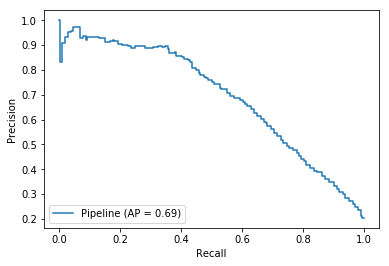

In [19]:
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(pipeline, X_test, y_test)


In [20]:
print(f"precision max is {precision.max()} on index {np.argmax(precision)} and recall is \
      {recall[np.argmax(precision)]} and threshold is {thresholds[np.argmax(precision)]} ")

print(f"recall {recall.max()} on index {np.argmax(recall)} and precision is \
        {precision[np.argmax(recall)]}  and threshold is {thresholds[np.argmax(recall)]}")


precision max is 1.0 on index 94 and recall is       0.003929273084479371 and threshold is 0.94 
recall 1.0 on index 0 and precision is         0.2036  and threshold is 0.0


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


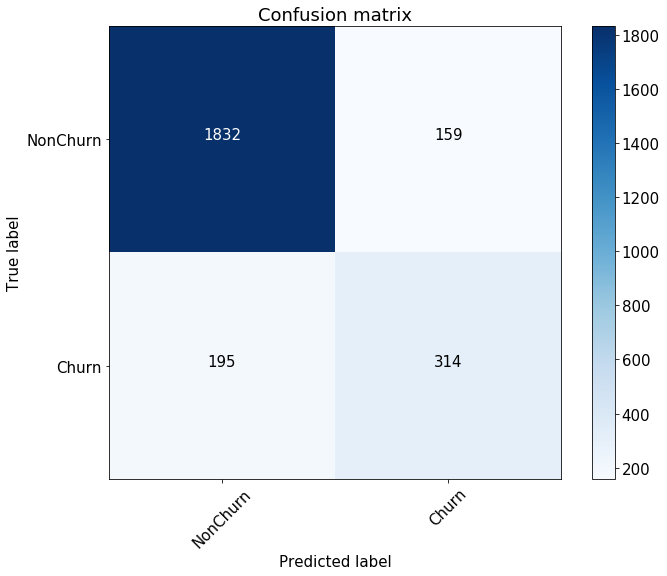

In [22]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми.

Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?

Ваш ответ здесь:
Если считаем, что при количестве NonChurn=1832 мы получим доход 3664 доллара, потратить по доллару на тех, кто по нашему мнению уйдёт, т.е. 159+314 = 373 доллара и получить впоследствии обратно 314*2=628 долларов является экономически оправданым (628-373=255 долларов, чуть больше 12% нашей прибыли) действием, при условии, что на разработку модели мы потратили меньше.



При цене на удержание 2 доллара и профите 2 можно не удерживать уходящих, т.к. при таком раскладе <strong>выйти в плюс мы не сможем</strong>, если только нам не даёт доппреимущество иметь как можно бОльшее число клиентов.


In [23]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

In [24]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.5,
 'classifier__min_samples_leaf': 3}

In [25]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.5, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.389431, F-Score=0.653, Precision=0.661, Recall=0.646
Confusion matrix, without normalization
[[1822  169]
 [ 181  328]]


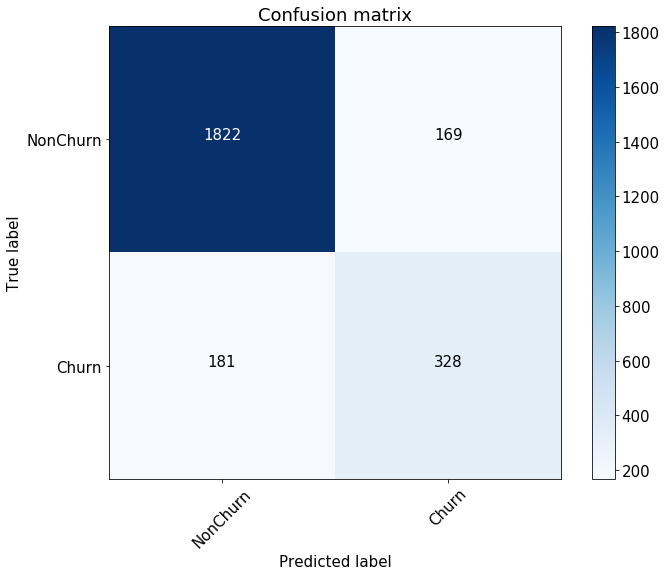

In [26]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

Попробуем другие модели. Скопируем пайплайн и добавим, где необходимо, дополнительную предобработку данных

In [28]:

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer


In [29]:
ct = make_column_transformer(
                            (StandardScaler(), continuous_columns),
                            (OneHotEncoder(), categorical_columns))

In [30]:
X_train.shape

(7500, 14)

In [31]:
ct.fit_transform(X_train).shape

(7500, 25)

In [32]:
ct.transform(X_test).shape

(2500, 25)

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
ct = make_column_transformer(
                            (MinMaxScaler(), continuous_columns),
                            (OneHotEncoder(), categorical_columns))

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('features', ct),
    ('classifier', GradientBoostingClassifier())
])

# pipeline = Pipeline([
#     ('features',feats),
#     ('classifier', GradientBoostingClassifier(random_state = 42)),
# ])

In [36]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Balance', 'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Geography', 'Gender',
                                                   'Tenure', 'HasCrCard',
                                                   'IsActiveMember'])])),
                ('classifier', GradientBoostingClassifier())])

In [37]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597
Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


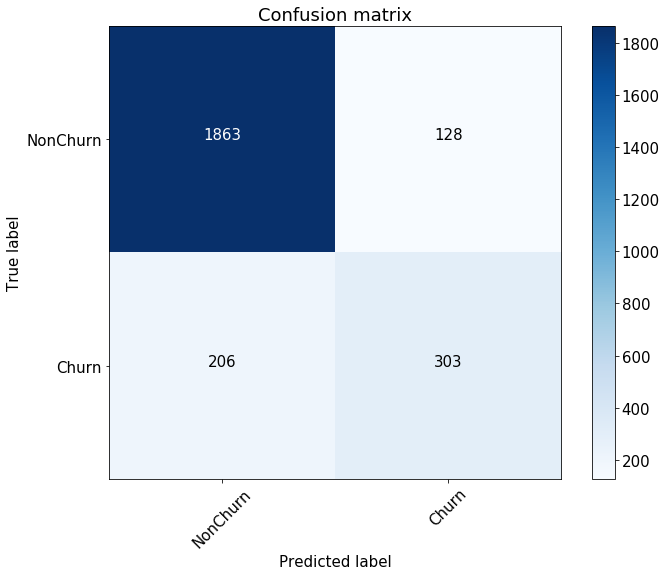

In [39]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [40]:
pipeline = Pipeline([
    ('features', ct),
    ('classifier', LogisticRegression())
])

In [41]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Balance', 'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Geography', 'Gender',
                                                   'Tenure', 'HasCrCard',
                                                   'IsActiveMember'])])),
                ('classifier', LogisticRegression())])

In [42]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.23147871, 0.33342815, 0.15457985, 0.12706248, 0.15737546,
       0.63172834, 0.06396248, 0.08071225, 0.35749076, 0.75533412])

Best Threshold=0.286079, F-Score=0.509, Precision=0.460, Recall=0.570
Confusion matrix, without normalization
[[1650  341]
 [ 220  289]]


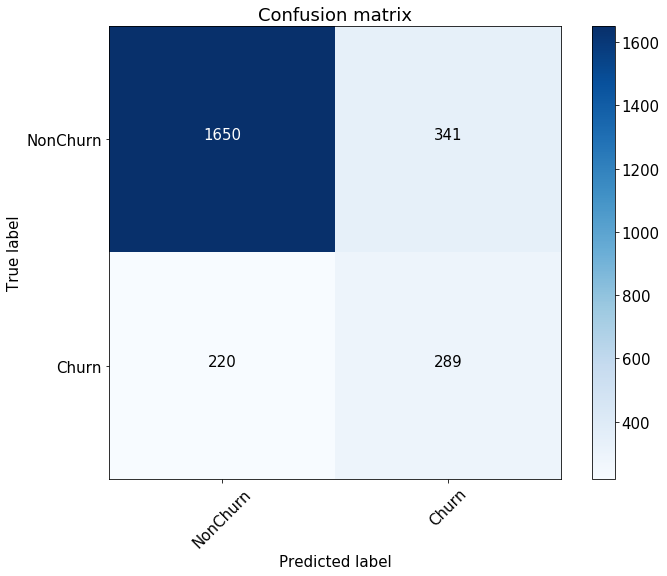

In [43]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

По результатам видно, что наш варианта с GradientBoostingClassifier немного лучше в precision, но хуже в recall. Попробуем сделать гридсёрч для GradientBoostingClassifier.

Вообще по вопросу, какая метрика лучше, нельзя сделать однозначный выбор. Если много денег на работу с возвратами, то следует взять recall. Если денег мало, precision. F1-скор как компромис.


Гридсёрч не получился по какой-то не очень понятной причине, к сожалению. Можете посмотреть?
Вроде названия параметров верные, а всё равно ошибка.

In [44]:
# parametrs ={
#     "clf__loss":["deviance"],
#     "clf__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "clf__min_samples_split": np.linspace(0.1, 0.5, 12),
#     "clf__min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "clf__max_depth":[3,5,8],
#     "clf__max_features":["log2","sqrt"],
#     "clf__criterion": ["friedman_mse",  "mae"],
#     "clf__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     "clf__n_estimators":[10, 100],
#     'verbose' : [True]
# }
# Работал больше 2 дней, результата нет. Пришлось сократить.

In [45]:
parametrs ={
    "clf__loss":["deviance"],
    "clf__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "clf__max_depth":[3,5,8],
    "clf__max_features":["log2","sqrt"],
    "clf__criterion": ["friedman_mse",  "mae"],
    "clf__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 1.0],

    'verbose' : [False]
}

In [46]:
#pipeline_gs.get_params()

In [47]:
ct_2 = ColumnTransformer(transformers=[('num', StandardScaler(), continuous_columns),
              ('cat', OneHotEncoder(), categorical_columns)])

In [48]:
pipeline_gs = Pipeline([
    ('features', ct_2),
    ('clf', GradientBoostingClassifier())
])

In [49]:
grid = GridSearchCV(pipeline_gs,
                    parametrs)


In [50]:
# %%time

# search = grid.fit(X_train, y_train)


In [51]:
# search.best_params_

In [52]:
parametrs ={
    "clf__loss":["deviance"],
    "clf__learning_rate": [0.05, 0.1, 0.2],
    "clf__max_depth":[3,5,8, 12],
    "clf__max_features":["log2","sqrt"],
    "clf__criterion": ["friedman_mse",  "mae"],
    "clf__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 1.0],

    'verbose' : [False]
}

In [53]:
grid2 = GridSearchCV(pipeline_gs,
                    parametrs)

In [54]:
grid2

GridSearchCV(estimator=Pipeline(steps=[('features',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Geography',
                                                                          'Gend

In [55]:
# %%time

# search2 = grid2.fit(X_train, y_train)

In [56]:
# search2 = grid2.fit(X_train, y_train)

In [57]:
# search2.best_params_

{'clf__criterion': 'friedman_mse',
 'clf__learning_rate': 0.1,
 'clf__loss': 'deviance',
 'clf__max_depth': 5,
 'clf__max_features': 'sqrt',
 'clf__subsample': 0.8,
 'verbose': False}
 
 Wall time: 4h 27min 56s



In [58]:
best_params_ = {'clf__criterion': 'friedman_mse',
 'clf__learning_rate': 0.1,
 'clf__loss': 'deviance',
 'clf__max_depth': 5,
 'clf__max_features': 'sqrt',
 'clf__subsample': 0.8,
 'verbose': False}

In [63]:
pipeline = Pipeline([
    ('features', ct_2),
    ('clf', GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss='deviance', max_depth=5,
     max_features='sqrt', subsample=0.8))
])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Balance', 'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Geography', 'Gender',
                                                   'Tenure', 'HasCrCard',
                                                   'IsActiveMember'])])),
                ('clf',
                 GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                            subsample=0.8))])

Best Threshold=0.324927, F-Score=0.641, Precision=0.613, Recall=0.672
Confusion matrix, without normalization
[[1775  216]
 [ 168  341]]


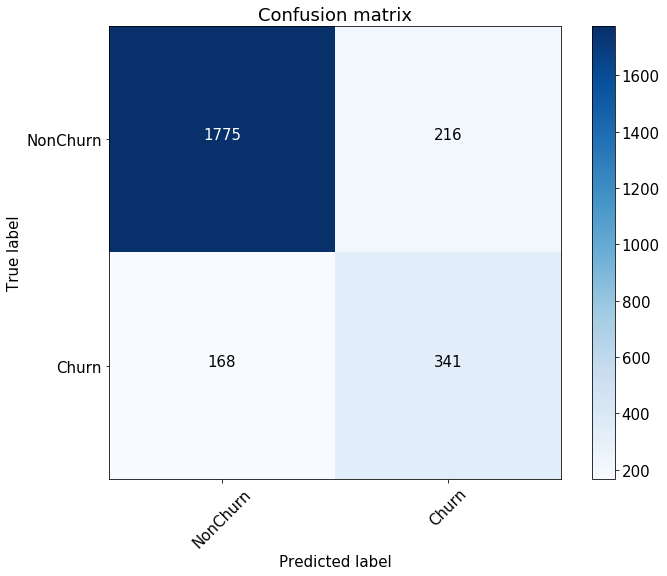

In [64]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597
Confusion matrix, without normalization

Относительно тренировки "по умолчанию", результаты оказались немного хеже  по F1-score, зато выровнялись recall и рercision. Скорее всего, тренировки нужно продолжать или сделать нормальный feature engineering, *только я не понимаю, что ещё можно сделать с признаками и не знаю, куда двигаться*. 
<strong>Можете подскаться хороший источник, где расписаны другие методы FE, помимо основных?</strong>

Повторный расчёт целесообразности можно не проводить, результаты примерно похожие. 